## Importing and formatting packaging data
In the first part of this code, we're going to import and format data from a simple packaging experiment for demonstration of this code.<br/>

The data is recorded in "force clamp" mode, where the position of the second trap is adjusted to keep the PSD voltage roughyl constant (using primitive feedback control). 
For this low resolution experiments, our data is stored as simple txt files. For each measurement, we record the PSD signal and the piezo mirror voltage in two separate txt files with the naming convention: `HH-MM-SS_TYPE_.txt`
<br/> First we'll define the directory to our code files and our raw data files, then load the piezo filenames and PSD filenames into separate cells using the function  `GetRawFileNames`:

In [37]:
cfold = 'dir to the matlab code files'; 
dfold_raw = 'dir to the raw data';
cd(cfold)
[piezofiles, psdfiles] = GetRawFileNames(cfold, dfold_raw);

Let's load and plot a measurement to see what the data looks like. Since the data were collected at a fixed sampling rate (sr in Hz), we can convert to time in seconds to dividing the number of data points by sr.

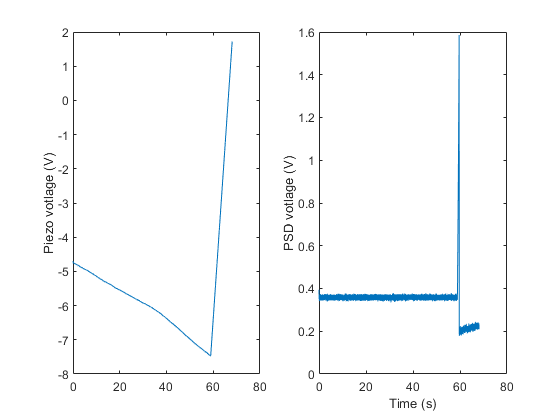

In [39]:
cd(dfold_raw)
vp = load(piezofiles{5}); %load piezo text file m('17-33-52_piezo_.txt')
vx = load(psdfiles{5}); %load PSD text file
sr = 1e3;                 %sampling rate
t = [1:length(vp)]'/sr;

figure()
subplot(2,1,1)
plot(t,vp); ylabel('Piezo votlage (V)');
subplot(2,1,2)
plot(t,vx); ylabel('PSD votlage (V)'); 
xlabel('Time (s)')

We have 3 features to initially worry about when we're importing this data:<br/>
**Multiple tether check**: If the tethering probability is too high, we may get more than one tether between our beads. These can be any mixture of inert, non-specific tethers and active packaging tethers. If the measurement ends by stretching the DNA until something dissociates, we can see the footprint of mutliple un-evenly long tethers by observing mutliple WLC force-extension curves with different contour lengths. We would like to detect the possibility of these events in our raw data and present them to the operator to decide whether or not<br/>
**Trap position ramping**: When our Labview program stretches the tether to trigger the force clamp, it can overshoot and stretch the tether to higher than our force clamp setpoint. Then the program will start recording data, but the trap will have to move back to a position where the force equals the set point. We want to exclude this "ramping" portion from our data, and later calculate an estimate of how much packaging activity could have occured during this segment to estimate our certainty in absolute tether length.<br/>
**Background PSD voltage**: The PSD voltage will always be non-zero if beads are caught in the traps. Our software records this value in order to set the force clamp to the correct value, but it currenty doesn't output it. To get it, we have to measure the PSD voltage from our data when the force is zero. In these type of measurements, we can do this after the DNA has been stretched to the point where the tether breaks. We want to find this region automatically.  <br/>

First, we'll check for multiple tethers using `GetPeakLocs`. This function scans `vx` for "peaks" which are indicative of points where the tether was broken by stretching. If there are no peaks, it detects where the tether broke naturally. If there are more than one peak detected, `inspect_multipletethers` is true, indicating that the user should manually inspect the trace. 


inspect_multipletethers =

  logical

   0




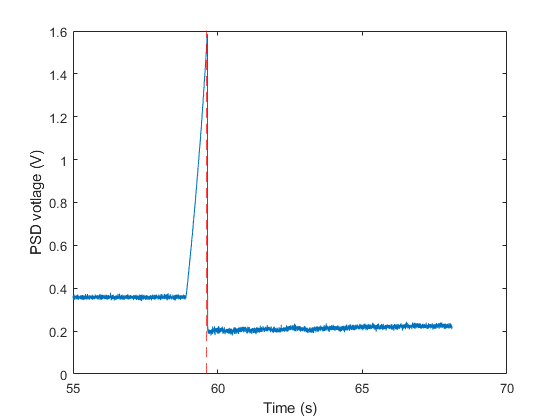

In [12]:
cd(cfold)
[locs, inspect_multipletethers] = GetPeakLocs(vp,vx, sr);

figure();
hold on
plot(t(55*sr:end),vx(55*sr:end)); ylabel('PSD votlage (V)')
xline(locs/sr,'r--','LineWidth',0.8)
hold off; xlabel('Time (s)'); box on;
inspect_multipletethers

We can see that the force peak is correctly identified and the user is not altered to inspect the trace manually. Now let's load two other examples:

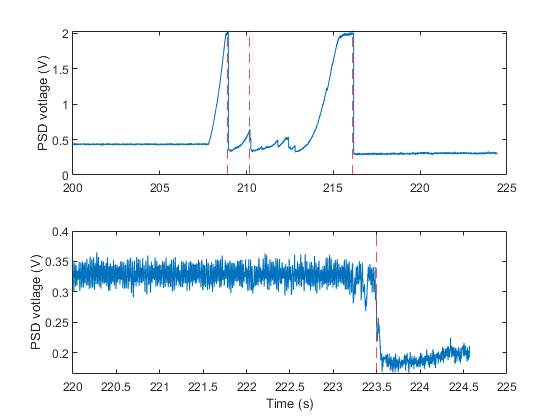

In [14]:
cd(dfold_raw)
vx0 = load('13-03-58_x_.txt'); vp0 = load('13-03-58_piezo_.txt'); 
t0 = (1:length(vx0))'/sr;
vx1 = load('10-52-24_x_.txt'); vp1 = load('10-52-24_piezo_.txt');
t1 = (1:length(vx1))'/sr;
cd(cfold)

figure()
subplot(2,1,1)
[locs, ~] = GetPeakLocs(vp0,vx0, sr);
hold on
plot(t0(200*sr:end),vx0(200*sr:end)); ylabel('PSD votlage (V)')
xline(locs/sr,'r--','LineWidth',0.8); box on; 
hold off

subplot(2,1,2)
[locs, ~] = GetPeakLocs(vp1,vx1, sr);
hold on
plot(t1(220*sr:end),vx1(220*sr:end)); ylabel('PSD votlage (V)')
xline(locs/sr,'r--','LineWidth',0.8)
hold off; xlabel('Time (s)'); box on;


In the first case, the function tells us to inspect the trace for multiple tethers since it found two force peaks. In the second, the tether appeared to break on it's own, so we don't get alerted to look at the file manually. Note: `GetPeakLocs` also has optional inputs to specify the ramping index (calculated next), the range over which the force clamp is calcuated, and the minimum peak absolute height and prominence, to help it perform best).

Now we want to automatically detect the force ramping in the beginning of the file, if it exists. To do this, we can use `GetRampingIndex`, which slides a window to detect when the `vx` value comes within a percentage of the clamp value. If the `vx` value initially is >1.3 times the clamp value, we mark the file for manual inspection to make sure it did a good job and that nothing weird is going on. For example: 

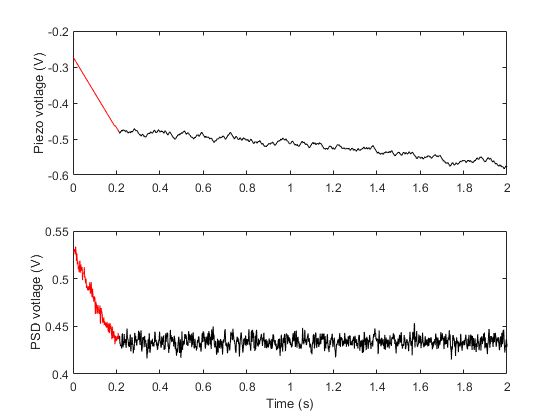

In [15]:
sr = 1e3;
ramp_params.win = sr/50; %window size in #datapts for ramp detection
ramp_params.slide = 0.5; %factor by which to slide ramp detection window
ramp_params.clampcutoff = 0.005; %sensitivity parameter for ramp detection

[iramp, inspect_ramp] = GetRampingIndex(vx0, sr, ramp_params);


figure()

subplot(2,1,1)
hold on
plot(t0, vp0,'k')
plot(t0(1:iramp), vp0(1:iramp), 'r')
hold off; box on; ylabel('Piezo votlage (V)')
xlim([0 2])


subplot(2,1,2)
hold on
plot(t0, vx0,'k')
plot(t0(1:iramp), vx0(1:iramp), 'r')
hold off; ylabel('PSD votlage (V)'); box on
xlabel('Time (s)')
xlim([0 2])

Now we'll detect the background voltage. We can get this directly from the data by averaging `vx` when there is no tether - after the tether was ruptured by us or on its own. To maximize accuracy, we measure this value over the same range of piezo voltages that the packaging measurement took place in (interference may cause the background voltage to do weird things when the tether is very short and the traps are close together). If that range wasn't covered, we output the ackground voltage as the value of `vx` in the last 1s. The background voltage will also be determined as the mean of the `vx` value in that range while excluding outliers (to adjust for some of the dropping force being captured). For example:

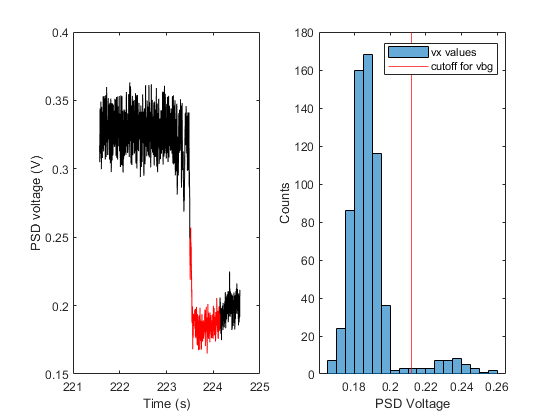

In [26]:
[locs, ~] = GetPeakLocs(vp1,vx1, sr);
[t_bg, vx_vbg, mean_vbg, ~] = GetBackgroundVoltage(vp1,vx1,sr, locs);


figure();
subplot(1,2,1)
hold on
plot(t1(end-3*sr:end), vx1(end-3*sr:end),'k')
plot(t_bg/sr, vx_vbg, 'r')
hold off; box on
xlabel('Time (s)'); ylabel('PSD voltage (V)')

subplot(1,2,2)
hold on
histogram((vx_vbg)); box on;
xlabel('PSD Voltage'); ylabel('Counts')
[~, index]= rmoutliers(vx_vbg); 
xline(vx_vbg(find(index==1,1,'last')), 'r')
hold off; legend({'vx values','cutoff for vbg'})

Another thing we want to calculate for all of our data: an estimate of the amount of DNA packaged during the fishing/ramping process. To-do this we use the fitted force-velocity relationship for the phi29 packaging motor. Tethers are aquired by putting the beads in close proximity, waiting (optional), then stretching to the clamp (or slightly past it), and relaxing. The tether probably forms when the beads are closest, so we'll calculate our estimate of the amount of DNA packaged during the wait/stretch process:

In [ ]:
%First we'll define parameters for this notebook (this is included in the
%code)

vp=vp1; vx=vx1-mean_vbg;
cal_params.alpha =38.5; cal_params.beta=990; cal_params.gamma=15; cal_params.vbump=-9;
[iramp, ~] = GetRampingIndex(vx, sr, ramp_params);
[~, imin] = min(smoothdata(vp,'gaussian',100));
ipkg=[iramp:imin]';
[fpkg,lpkg] = lcalcbeta(vx(ipkg), vp(ipkg),cal_params);


%Force-velocity relationshhip from Liu et al Cell 2014
vforcedata = [2.8990228013029284, 93.77576181923347
                4.983713355048856, 100.4657676032756
                6.938110749185665, 85.6628816706749
                10, 78.31593046972512
                14.885993485342016, 65.88815489055983
                20.032573289902277, 61.866723492343766
                24.853420195439742, 55.79530579317485
                30.000000000000004, 47.474808974398016
                35.0814332247557, 40.277025175804454
                40.03257328990229, 36.07233096897929];

force = vforcedata(:,1); 
vmotor = vforcedata(:,2)./100;
p = fit(force, vmotor, 'Exp1'); 

%Input parameters
delay_time_on = 1; %if 1, assume that tether starts packaging at the mid point of the delay time 
tdelay = 0.1;  %typical delay time - this depends on the experiment
vbead_fish = 10; %[V/s] Fishing bead movement speed
Vbump = -8; %depends on bead size
alpha=38.5; %force cal parameter
sr=1e3; %Sample rate

% 1. Calculate amount of packaging during force ramp
%   LengthPackaged_ForceRampDown

t_miss = ipkg(1)/1e3; %this is the amount of time that the thing is ramping down
framp = alpha*vx(1:ipkg(1)); %this is the force during the ramping down segment (NOTE: this is a little inaccurate because of the background difference)

%Measure the velocity in the first 5s of packaging (non-zero force)
% mean_background_difference = 1.26; %to account for the fact that we don't know the packaging force super accurately, I measured the mean fslip-5pN difference. 
vinitial = sr*(lpkg(1) - lpkg(5*sr))/(5); %velocity in bp
fpkg = (alpha*(mean(vx(ipkg(1):ipkg(5*sr)))));

%Find the zero-force velocity based on vinitial
vzero = vinitial * p.a*exp(-p.b*fpkg);

%Find the velocity during the ramp
vramp = vzero * p.a*exp(p.b*framp);

% Integrate the curve to find the prefill error 
if length(framp) > 2
    t = (1:length(vramp))/sr; %packaging time (s)
    LengthPackaged_ForceRampDown = trapz(t,vramp); %length packaged during movement in basepairs
end

% 2. Calculate the amount of DNA packaged during the ramp from
%    ideal setpoint to real setpoint
%    LengthPackaged_ForceRampUp
if mean(framp) > fpkg %If the setpoint was too high and the force increased past the force clamp value

    vbead_fc = max(diff(vp)); %Find the step size for the force clamp
    vbead_fc = sr*vbead_fc;  %Speed (V/s) of bead movement during force clamp mode

    dt_down = t(end) - t(1);
    dt_up = (vbead_fc/vbead_fish)*dt_down; %this is how long it takes to ramp up
    t_upramp = 1e-3:1e-3:dt_up;

    if ~isempty(t_upramp)
        f_upramp = flip(resample(framp,length(t_upramp),length(t))); %Resample so that t_upramp and F_upramp are the same size

        v_upramp = vzero * p.a*exp(p.b*f_upramp); %calculate velocity during ramp up

        if length(f_upramp) > 2
            LengthPackaged_ForceRampUp = trapz(t_upramp,v_upramp);
        end
    end

end

%3. Calculate amount packaged during fishing, moving from bump
%   voltage to ideal set point voltage
%   LengthPackaged_Fishing
dt_fish = ((vp(ipkg(1))-Vbump)/vbead_fish);
LengthPackaged_Fishing =  vzero*dt_fish;

%4. If there were some delay time, calculate the amount packaged
%   during that delay.
%   LengthPackaged_DelayTime
if delay_time_on == 1

   dt_delay = tdelay/2; %tether forms halfway during delay time on average (not really since the activity decreases with time but assume it does)
   LengthPackaged_DelayTime =  vzero*dt_delay;


end

% Add total amount of missed length packaged (in bp)
length_missed = LengthPackaged_ForceRampDown+LengthPackaged_ForceRampUp+LengthPackaged_Fishing;


This calculation is done in the function Calculate_lengthmissed after the rest of the pre-processing.
The script Analysis_ImportTxt runs each of these functions while importing text data and allows the user to manually correct any of them if they malfunction. The relevant variables for each complex are saved into a .mat file in the directory defined by depfold , they are: <br/>
`vp`: Piezo voltage<br/>
`vx`: PSD voltage-background<br/>
`vbg`: Background voltage<br/>
`fpkg`: Mean force clamp during packaging<br/>
`lpkg`: Tether length calculated from piezo voltage, psd voltage, tweezer calibration parameters, and the elasticity of the DNA modeled by the WLC using apprximate persistence length and stretch modulus values for DNA in the phi29 packaging buffer (P=50nm, S=1200 pN)<br/>
`ipkg`: Index of vp,vx data that corresponds to lpkg. Note: `ipkg(1)` = `iramp` (end of ramping)<br/>
`length_missed`: Estimate of DNA length packaged during ramping<br/>

## Calculating packaging rate and motor velocity

Now that we have our data properly formatted, imported, and converted to physical units, we can start doing some analysis. <br/>

The packaging motor has 3 states: packaging, paused, slipping. Our job is to figure out what it is doing despite experimental noise. The rate at which the motor packages is called the motor velocity, while the  rate at which it packages including slipping and pausing is called the packaging rate. By looking at the traces, you can tell that the packaging rate changes as a function of amount of DNA packaged. 

To measure the motor velocity as a function of amount of DNA packaged (or equivalently filling, filling = amount of DNA packaged / phi29 genome length , and phi29 genome length = 19,282 bp ) we will chop up the data into windows small enough that we can assume the motor velocity is constant within a window, then we will apply a Savitsky-Golay differentiating filter to get an estimate of the 1st derivative at each point. Then we will fit a bimodal distribution to the derivative with a low-value peak (pausing/slipping) and a higher value peak (packaging). For example:

> In mlecustom (line 297)
In mle (line 304)



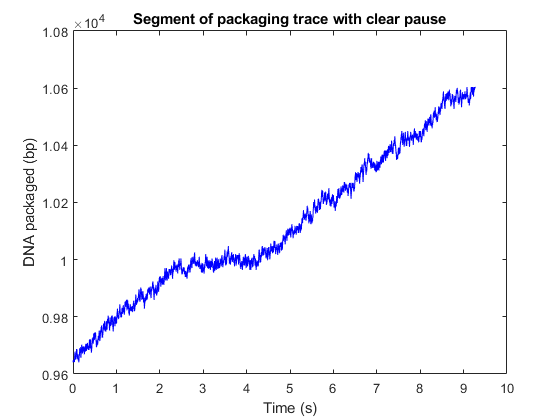

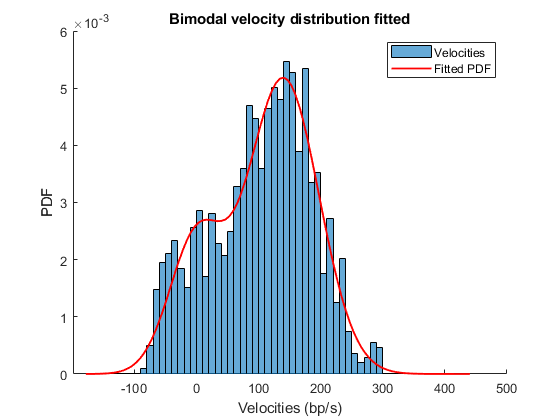

In [28]:
%Import and convert data
cd(dfold_raw)
vp = load('14-33-50_piezo_.txt'); %load piezo text file m('17-33-52_piezo_.txt')
vx = load('14-33-50_x_.txt'); %load PSD text file
cd(cfold)
[locs, inspect_multipletethers] = GetPeakLocs(vp,vx, sr);
[iramp, ~] = GetRampingIndex(vx, sr, ramp_params);
[~, ~, mean_vbg, ~] = GetBackgroundVoltage(vp,vx,sr, locs);
vx=vx-mean_vbg;
cal_params.alpha =38.5; cal_params.beta=990; cal_params.gamma=15; cal_params.vbump=-9;
[~, imin] = min(smoothdata(vp,'gaussian',100));
ipkg=[iramp:imin]';
[fpkg,lpkg] = lcalcbeta(vx(ipkg), vp(ipkg),cal_params);

%Convert to DNA packaged in bp
% nsmooth = 10;
trace=1e3*(mean(lpkg(1:50))-lpkg);


%Plot segment of trace we are interested in calculating the velocity for:
pkgrange = 1e4*[0.9641, 1.0605];
trace_seg = trace(trace>= pkgrange(1) & trace<=pkgrange(2));
figure()
hold on
plot((1:length(trace_seg))/sr, trace_seg,'b')
hold off
xlabel('Time (s)'); ylabel('DNA packaged (bp)'); 
box on; title('Segment of packaging trace with clear pause')

%Apply SG filter to this segment and calculate 1st derivative
frames = floor(sr)+1;
order = 5; 
[b,g] = sgolay(order,frames);
dt  = 1/sr; 
vels = conv(trace_seg, factorial(1)/(-dt) * g(:,2), 'same');
vels = rmoutliers(vels); %remove artifact from beginning and end of trace


%Fit distribution with mix of gaussians:

%Define the mixutre PDF
pdf_binorm = @(x,p,mu1,mu2,sigma1,sigma2) p*normpdf(x,mu1,sigma1) + (1-p)*normpdf(x,mu2,sigma2);

%Define starting point. 1: pause/slip peak, 2:packaging peak
p0 = 0.5;  %probability of getting a pause (initial guess)
m0 = [0, median(vels)];        %0 mean for pausing, higher vel for packaging
s0 = 50; %assume same std. dev. to start
start = [p0 m0 s0 s0];

%Set bounds and perform fit
lb = [0 -Inf -Inf 0 0]; %bounds for the mixing prob, mean, and sigma
ub = [1  20 Inf Inf Inf]; %Note: We know our pause mean shouldn't be higher than ~20s based on control tether data
options = statset('MaxIter',1e3); %set large number of max iterations
dist_params = mle(vels,'pdf',pdf_binorm,'Start',start,'LowerBound',lb,'UpperBound',ub,'Options',options);

%Plot hisotgram
figure()
hold on
histogram(vels,'Normalization','pdf')
xplot = linspace(1.1*min(vels),1.1*max(vels),100);
pdfgrid = pdf_binorm(xplot, dist_params(1),dist_params(2), ...
    dist_params(3),dist_params(4),dist_params(5));
plot(xplot,pdfgrid,'r-', 'LineWidth',1.4)
hold off
xlabel('Velocities (bp/s)')
ylabel('PDF')
legend('Velocities','Fitted PDF')
title('Bimodal velocity distribution fitted')

Keeping track of all velocities vs amount packaged can give us an idea of what the packaging rate is doing as a function of filling for an individual complex.

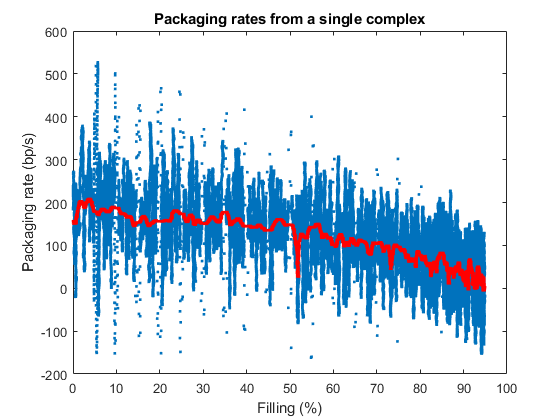

In [29]:
% Chop into segments based on filling
Lphi29=19282; %length of phi29 genome in basepairs
filling_bin = 5; %size of filling bin (%)
fillrange = [0:filling_bin:5*floor((100*max(trace)/Lphi29)/5)]';
fillrange(:,2) = fillrange+filling_bin;
    
trace_data = [];
vel_data = [];


for k=1:size(fillrange,1)
    %Isolate
    pkgrange = Lphi29*fillrange(k,:)/100; %convert filling range to length packaged
    trace_seg = trace(trace>= pkgrange(1) & trace<=pkgrange(2));

    %Estimate derivates from SG output above
    vels = conv(trace_seg, factorial(1)/(-dt) * g(:,2), 'same');

    %Remove outliers and append values and keep track of values
    [vels,rm]  = rmoutliers(vels);
    trace_seg=trace_seg(~rm);
    trace_data = [trace_data; trace_seg];
    vel_data = [vel_data; vels];

end

%Plot against filling
figure()
hold on
plot(100*trace_data/Lphi29, vel_data,'.')
plot(100*trace_data/Lphi29, smoothdata(vel_data, 'gaussian', 3e3),'r.')
hold off
xlabel('Filling (%)'); ylabel('Packaging rate (bp/s)'); box on;
title('Packaging rates from a single complex')

Now to get the average packaging rate or motor velocity vs filling, we just average together the packaging rate or motor velocity vs filling data for many different complexes

## Step fitting to determine pause locations and durations - Kernel density estimation

Since we're also interested in quantifying the characteristics of pauses in our data, we need a way to automatically detect pauses. This class of problems is called change point detection, and it is relevant to pause detection in our low-resolution data, and pause detection in high-resolution data, where pauses are chemical states of the motor during which nucleotide exchange occurs (dwells) and steps between pauses are states where ATP hydrolysis occurs and the tether length changes rapidly. There are many ways to detect pauses, but here I'll present two common methods that can be used together. They are Kernel Density estimation and the Schwarz Information Criterion algorithm (Kalafut and Visscher, 2008). 

First, Kernel Density Estimation - also known as the residence time histogram. In this method we apply a downsampling filter to our data, and data within that downsampling window are replaced by an average. Then for each window, we construct a normal PDF (unit area) where the width is proportional to the standard deviation of the data points in the downsampling window. We then add these PDF's together and look for the locations of peaks, which indicate that the tether spent more time there than in other locations. Below is an implementation of this algorithm. First, we'll generate simulated stepping data. Stepping data consists of motor activity in two states: burst and dwell, where the dwell time is gamma distributed (sum of rates for nucleotide exchange), the burst duration is much shorter than the dwell time and gamma distributed (sum of hydrolysis rates), and the burst step size is fixed by subject to instrument noise:

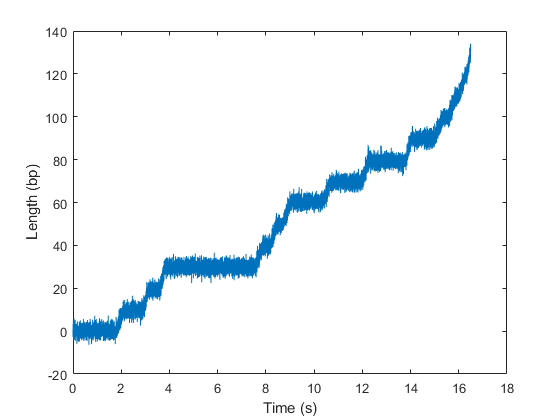

In [31]:
%Set the number of steps and the sampling rate
nsteps = 15;
sr=1000;
%Generate dwell times, burst sizes and duration
dwells = random('Gamma',1,0.5,nsteps,1);select = (dwells>0.05); %Generate dwell times
dwells=dwells(select);
burstsizes = random('Normal',10,0.5,nsteps,1); %Generate burst sizes (instrument noise)
burstsizes=burstsizes(select);
burstdurations = random('Gamma',25,0.01,nsteps,1); %Generate burst durations
burstdurations=burstdurations(select);

%Construct tether length
tether_length = [0.1];
for i=1:length(dwells)
    %Dwelling
    tl_dwell = tether_length(end)*ones(floor(sr*dwells(i)),1); 
    tl_dwell=reshape(tl_dwell,[length(tl_dwell),1]);
    %Stepping
    tl_burst = linspace(tl_dwell(end), tl_dwell(end)+burstsizes(i), burstdurations(i)*sr);
    tl_burst=reshape(tl_burst, [length(tl_burst),1]);
    tether_length = [tether_length; tl_dwell; tl_burst];
end

%Add some white noise
noise = normrnd(0, 2, length(tether_length),1);
trace_raw = tether_length+noise;
time=(1:length(trace_raw))'/sr;
figure()
plot(time, trace_raw); box on; xlabel('Time (s)'); ylabel('Length (bp)')
title('Simulated packaging data w')

Now on to KDE. First, we downsample to construct our kernel desnity:


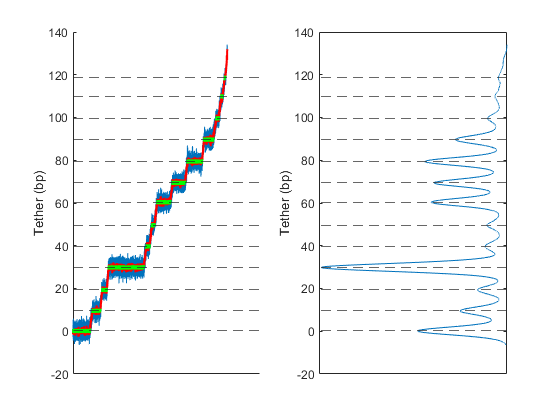

In [32]:
downsample_factor=1e1;
slidefactor = 1; winslide = downsample_factor*slidefactor;
xplot = linspace(min(trace_raw),max(trace_raw), length(trace_raw)); %region over which we evaluate the normal PDF
kerneldesnity = zeros(length(xplot),1); %initialize
norm = @(x, sigma, mu) (1/(sigma*sqrt(2*pi)))*exp(-0.5*((x-mu)/sigma).^2); %normal PDF
for ts=1:winslide:length(trace_raw)-downsample_factor
    tbin = ts:ts+winslide; %index of points in the window
    mu = mean(trace_raw(tbin)); %mean of points in the window
    s = std(trace_raw(tbin)); %std deviation of points in the window
    data = norm(xplot,s, mu)';
    kerneldesnity = kerneldesnity+data;
end

[~,locs] = findpeaks(kerneldesnity); %Find the peaks in the kernel density

%To decide what data we include based on the kernel density peaks, we can
%use a cutoff for distance to the peak location
distance_cutoff = 1; %this should be adjusted based on the resolution of the data 

figure();
ax1=subplot(1,2,1);
    index=[1:length(trace_raw)]';
    hold on
    plot(trace_raw)
    trace_smooth = smoothdata(trace_raw, 'lowess', 10);
    plot(trace_smooth,'r' ,'LineWidth',1.5)
    yline(xplot(locs),'--')
    for k=1:length(locs) %for each peak location ... 
        select = (abs(trace_smooth-xplot(locs(k))) < distance_cutoff);
        plot(index(select), trace_smooth(select), 'g', 'LineWidth',1.4)
    end
    hold off
    xlabel('');xticks(''); ylabel('Tether (bp)')
    title('Packaging trace')
ax2=subplot(1,2,2);
    hold on
    plot(kerneldesnity,xplot)
    yline(xplot(locs),'--')
    hold off
    set ( gca, 'xdir', 'reverse' )
    box on
    xlabel('');xticks(''); ylabel('Tether (bp)')
    title('Kernel density')
linkaxes([ax1,ax2],'y')

## Step fitting to determine pause locations and durations - SIC score model fitting alogrithm

Now we can move on to the Schwarz Information Criterion (SIC) algorithm. This was first published in B.Kalafut and K.Visscher, Comp. Phys. Comm. 179 (2008). The basic idea is to discriminate between different models based on a function of the likelihood for that model. In this algorithm, the Schwarz Information Criterion (Bayes Information Criterion) is used [insert definition]. The algorithm finds the location of a step that minimizes the SIC, then tests the SIC for 1 step against the SIC for no steps. If the step hypothesis has a lower SIC, the step is recorded and the process is repeated iteratvely until adding more steps does not lower the SIC anymore. Since this naive implementation tends to over fit steps to our noisy data, we then go through and merge or throw out detected steps based on some criteria derived from the noise characteristics of our data. First, we need a function that calculates the SIC score (found in `SICScore.m` ), shown below:

In [33]:
% function score = SICScore(trace, edges)
%Calculates the SIC for a given model.
edges = 1;
N = length(trace);
sigma_k = 0;

for i = (1:length(edges)-1)
    lb = edges(i);
    ub = edges(i+1);
    if ub-lb<5
        continue
    end
    
    %Crop trace and calculate terms for SIC
    trace_crop = (trace(lb:ub))';
    error = trace_crop - mean(trace_crop);
    sigma_k = sigma_k + sum((error).^2);

end

sigma_k = sigma_k/N;
k = length(edges)-1;
score = (k+2)*log(N) + N*log(sigma_k);

    
% end

Now we can run the algorithm to get an initially over-fit edge detection


In [34]:
trace_cropped = smoothdata(trace_raw, 'lowess', 10); %smooth the trace initially
Niter = 20; %number of iterations to run on initial detection
edges = [1, length(trace_cropped)]; %set first edges
score = SICScore(trace_cropped, edges); %calcuklate no change SIC 

for k = 1:Niter 
    edge_buff = []; 
    for i = (1:length(edges)-1)
        lb = edges(i);%Upper/lower bound of edges
        ub = edges(i+1);
        trace_crop = (trace_cropped(lb:ub)); %crop trace
        new_edge = AddEdge(trace_crop); %Scan for new min SIC score using AddCutPoint
        if new_edge ~=0 %If a new edge was detected
            edge_buff = [edge_buff, lb+new_edge]; %Keep track of new edges
        end
    end
    if length(edge_buff) ~= 0 
        edges = sort([edges, edge_buff]);
    end
    
end

Let's see what was detected: 


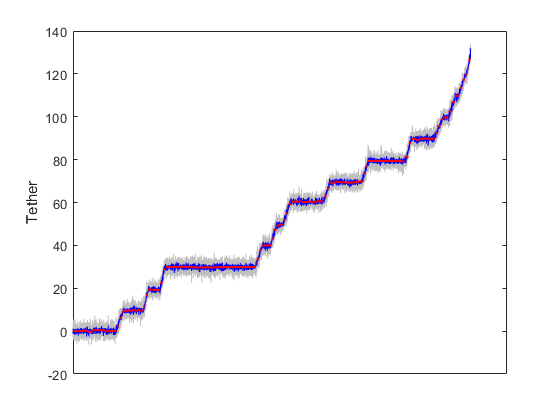

In [35]:
hold on
plot(trace_raw, 'Color', 0.75*[1,1,1])
plot(trace_cropped, 'b')
for i=1:length(edges)-1
    lb = edges(i); ub=edges(i+1);
    val = median(trace_cropped(lb:ub));
    plot(lb:ub, val*ones(length(lb:ub),1),'r' ,'LineWidth',1.5);
end
xticks(''); ylabel('Tether'); box on;
title('Initial step detection')

We can see that sometimes dwells are split into multiple steps. Let's merge them:


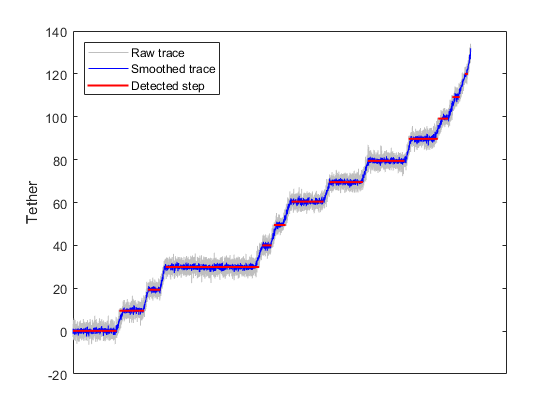

In [36]:
%First we'll define some parameters for merging the steps. These will
%depend heavily on your data
time_cutoff=150; %Steps separated in time by >this are not merged (in # datapts)
length_cutoff = 5; %Steps separated in length by >this are not merged (in #datapts)
slope_cutoff=30; %Dwells with velocities >this are thrown away (in units of trace/s)


%First we'll get rid of dwells that are clearly packaging
edges_filter = []; %initialize new edge array
for i = 1:length(edges)-1

    %Crop time and tether length within edge
    lb = edges(i); ub = edges(i+1);
    trace_crop1 = (trace_cropped(lb:ub));
    time_crop1 = (time(lb:ub));
    
    %Fit a line to the tether length vs time to find velocity
    linearfit = fit(time_crop1, trace_crop1, 'poly1');

    %Do not include steps with too large velocity
    if abs(linearfit.p1)>slope_cutoff %slope is too large?
        continue;
    else %include
        edges_filter = [edges_filter; [lb, ub]];

    end
    
end


%Now merge based on separation of steps
row = length(edges_filter)-1;
while row>=1

    %Is the time between the end of one edge and the beginning of
    %the next lower than the cutoff?
    check_time = edges_filter(row,2)>=edges_filter(row+1,1)-time_cutoff; 

    %Is the distance between the detected dwells less than the cutoff?
    check_length = (median(trace_cropped(edges_filter(row+1,1):edges_filter(row+1,2)))-...
    median(trace_cropped(edges_filter(row,1):edges_filter(row,2))))< length_cutoff ; 

    %Merge the detected dwells if they match criteria
    if  check_time && check_length 
        edges_filter(row,2) = edges_filter(row+1,2);
        edges_filter(row+1,:) = [];
    end

    %Move on to the next row
    row = row-1;
    
end

%Now let's plot the trace with the dwells marked
figure();
hold on;
plot(time, trace_raw, 'Color', 0.75*[1,1,1])
plot(time, trace_cropped, 'b');
for k = 1:size(edges_filter,1)
    lb = edges_filter(k,1);
    ub = edges_filter(k,2);
    trace_crop = (trace(lb:ub))';
    time_crop = (time(lb:ub))';
    plot(time_crop, ones(size(time_crop))*median(trace_cropped(lb:ub)),'r', 'LineWidth',1.5)
end
legend('Raw trace', 'Smoothed trace', 'Detected step', 'Location', 'northwest'); box on;
title('Steps detected and merged')
xticks(''); ylabel('Tether')

Great! We've done a good job of detecting steps in this data. For real data, the SIC score needs to be adjusted to reduce the incidence of overfitting by increasing the penalty for the number of steps. Also, we will need to adjust the various parameters that we use for cutoffs in merging the steps. Those parameters depend on the burst sizes and durations and how noisy our data is, which can have variations between experiments due to changing, for example, the bead size or DNA construct length, or variations within experiments due to fluctuations in the bead shape/size, or contaminants on the bead, for example. 